# Tercer Examen Parcial (Práctico)
### Laboratorio de Aprendizaje Estadístico

José Armando Melchor Soto  | 745697

--- 




### Librerías: 

In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.formula.api as smf
import warnings
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from xgboost import XGBRegressor
import seaborn as sns
from lightgbm import plot_importance
from xgboost import plot_importance as xgb_plot_importance
from sklearn.neighbors import KNeighborsClassifier




warnings.simplefilter(action='ignore', category=FutureWarning)

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

---

### Dataset : 
Diabetes

In [ ]:
df = pd.read_csv('diabetes.csv')

In [ ]:
df.head()

#### Dummies

In [ ]:
df = pd.get_dummies(df, drop_first=True)
df

### Visualización del Dataset

In [ ]:
df.head()

In [ ]:
print(df.columns)


### Explicación de las variables

---

#### Se busca predecir

In [ ]:
target= 'diabetes'
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### NaN's

In [ ]:
pd.DataFrame(df.isnull().sum()).T

Ninguna Variable tiene NaN's , así que podemos continuar

##### Función Calibración 

In [ ]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    gropuped = df_calibracion.groupby('bins').mean()
    
    plt.plot(gropuped.predicciones, gropuped.y, label="Modelo", marker="o")
    plt.plot(gropuped.predicciones, gropuped.predicciones, label="Real", marker="o")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

##### Función Bivariado

In [ ]:
def bivariado(df):
    num_features = df.iloc[:, :].columns
    df_numerical = df.iloc[:, :].copy()

    for feature in num_features:
        df_numerical[f'{feature}_bins'] = pd.qcut(df_numerical[feature], q=5, labels=False, duplicates='drop')

        if df_numerical[f'{feature}_bins'].isna().sum() > 0:
            print(f"Advertencia: {feature} tiene valores NaN en la segmentación.")

        grouped = df_numerical.groupby(f'{feature}_bins').mean()

        fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 
        
        sns.lineplot(x=grouped[feature], y=grouped[target], marker='o', color='#b30000', ax=axes[0])
        axes[0].set_title(f'Relación de {feature} con {target}')
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel(target)
        axes[0].grid()

        sns.histplot(df_numerical[feature], bins=50, color='#b30000', edgecolor='black', kde=True, ax=axes[1])
        axes[1].set_title(f'Distribución de {feature}')
        axes[1].set_xlabel(feature)
        axes[1].set_ylabel('Frecuencia')

        plt.show()


##### Función Lightgbm

In [ ]:
def lightgbm(X_train, y_train, X_test, y_test):

    model_lightgbm = LGBMRegressor(
        num_iterations=10000,
        num_leaves=10,
        learning_rate=0.1,
        max_depth=20,
        lambda_l2=0.1,
        subsample=0.5,
        feature_fraction=0.8,
        verbosity=-1,
        metric='rmse'
    )

    model_lightgbm.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='rmse',
        callbacks=[
            early_stopping(stopping_rounds=20),
            log_evaluation(period=100)
        ]
    )

    predicciones_lightgbm = model_lightgbm.predict(X_test)
    print("R^2", r2_score(y_test, predicciones_lightgbm))
    calibracion(predicciones_lightgbm, y_test, 20)
    plot_importance(model_lightgbm, max_num_features=5, importance_type='split')
    plot_importance(model_lightgbm, max_num_features=5, importance_type='gain')


##### Función CatBoost

In [ ]:
def catboost( X_train, y_train,X_test,y_test):
    cat_cols = [col for col in X_train.columns if X_train[col].nunique() < 50]


    for col in cat_cols:
        X_train[col] = X_train[col].astype(str).fillna('missing')
        X_test[col] = X_test[col].astype(str).fillna('missing')

    model_catboost = CatBoostRegressor(
        iterations=10_000,           
        depth=5,                   
        learning_rate=0.1,
        subsample=0.5,              
        rsm=0.8,                   
        eval_metric='R2',
        verbose = 100,
        early_stopping_rounds=50    
    )

    model_catboost.fit(
        X_train, y_train,
        cat_features=cat_cols,
        eval_set=[(X_test, y_test)],
    )

    predicciones_catboost = model_catboost.predict(X_test)
    print('R^2:' ,r2_score(y_pred=predicciones_catboost, y_true=y_test))
    calibracion(predicciones_catboost, y_test, 20)


    df_importances = pd.DataFrame({
        'feature': model_catboost.feature_names_,
        'importance': model_catboost.feature_importances_
    }).sort_values(by='importance', ascending=False)
    return df_importances.head(5)


##### Función XGBoost

In [ ]:
def xgboost(X_train, y_train, X_test, y_test):

    model_xgboost = XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        reg_lambda=0.1,
        subsample=0.5,
        colsample_by_tree=0.8,
        tree_method='hist',
        enable_categorical=True,
        early_stopping_rounds=100,
    )

    model_xgboost.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

    predicciones_xgboost= model_xgboost.predict(X_test)
    print(f'R^2:',r2_score(y_test, predicciones_xgboost))
    calibracion(predicciones_xgboost, y_test, 20)

    xgb_plot_importance(model_xgboost, max_num_features=5, importance_type='weight')
    xgb_plot_importance(model_xgboost, max_num_features=5, importance_type='gain')



#### Bivariado

In [ ]:
bivariado(df)

#### **Modelo**

Se pide que el modelo tenga: 

test set: 20%
random_state: 42

#### Correlación

In [ ]:
df.corr()['diabetes'].sort_values(ascending=False)

In [ ]:
df.drop('gender_Other', axis=1, inplace=True)

In [ ]:
df.corr()['diabetes'].sort_values(ascending=False)

## **Modelos**

## Arboles de decisión

Arbol con `max_depth`= 2 

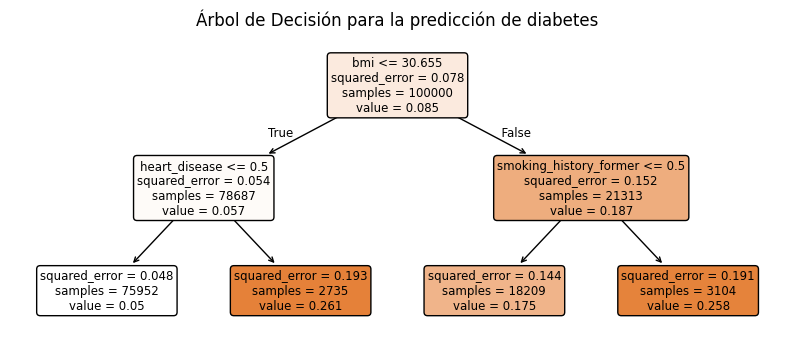

In [213]:
model = DecisionTreeRegressor(max_depth=2, random_state=42, 
                                  max_features='sqrt')
model.fit(X, y)

plt.figure(figsize=(10, 4)) 
plot_tree(model, feature_names=X.keys(), filled=True, rounded=True)
plt.title("Árbol de Decisión para la predicción de diabetes")
plt.show()


---

## Random Forest

### GridSearch

In [ ]:
pipeline= Pipeline([
    ('rf', RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42))
])

params= {
    'rf__max_depth': range(1, 50),
    'rf__max_features': ['log2', 'sqrt', 18 ,len(X_train.keys())],  
}

rf_grid= GridSearchCV(estimator= pipeline, param_grid=params, cv=5, n_jobs=-1, scoring='r2')
rf_grid.fit(X_train, y_train)

rf_grid.best_params_

In [ ]:
best_model= rf_grid.best_estimator_.named_steps['rf']

In [ ]:
predicciones_rf= best_model.predict(X_test)

print('R2: ', r2_score(y_pred= predicciones_rf, y_true=y_test))

### RandomSearch

---

## Gradient Boosting

### Xgboost

In [ ]:
xgboost(X_train, y_train, X_test, y_test)

#### Lightgm

In [ ]:
lightgbm(X_train, y_train, X_test, y_test)

### Catboost

In [ ]:
catboost(X_train, y_train, X_test, y_test)